In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.stats as stats
from scipy.spatial.distance import pdist, squareform

from tqdm import tqdm

In [2]:
# DATA_DIR = '../../datasets/NNN/unit_data_full.pkl'
DATA_DIR = '../../datasets/NNN/face_roi_data.pkl'
dat = pd.read_pickle(DATA_DIR)
print(f'Sucessfully loaded data for {len(dat)} units!')

Sucessfully loaded data for 5133 units!


In [18]:
np.min(dat['F_SI']), np.max(dat['F_SI'])

(np.float64(-3.483745813369751), np.float64(5.77348518371582))

In [6]:
# img_psth = dat['img_psth'].iloc[0]

# ONSET_TIME = 50
# RESPONSE_WIN = slice(ONSET_TIME + 50, ONSET_TIME + 220)
# BASELINE_WIN = slice(ONSET_TIME - 50, ONSET_TIME + 0)

# # baseline normed response to 1072 different images
# normed_response = img_psth[RESPONSE_WIN, 1000:].mean(axis=0) - img_psth[BASELINE_WIN, 1000:].mean(axis=0)

# stats.ttest_rel(img_psth[RESPONSE_WIN, 1000:].mean(axis=0), img_psth[BASELINE_WIN, 1000:].mean(axis=0))
ONSET_TIME = 50
RESP_WIN = slice(ONSET_TIME + 50, ONSET_TIME + 220)
BASE_WIN = slice(ONSET_TIME - 50, ONSET_TIME + 0)
IMG_SLICE = slice(1000, None)

def unit_pvalue(A):
    A = np.asarray(A)
    resp = A[RESP_WIN, IMG_SLICE].mean(axis=0)
    base = A[BASE_WIN, IMG_SLICE].mean(axis=0)

    m = np.isfinite(resp) & np.isfinite(base)
    if m.sum() < 2:
        return np.nan
    return stats.ttest_rel(resp[m], base[m]).pvalue

dat['p_value'] = [unit_pvalue(A) for A in dat['img_psth']]
dat.to_pickle(DATA_DIR)

Text(0.5, 1.0, 'B_SI')

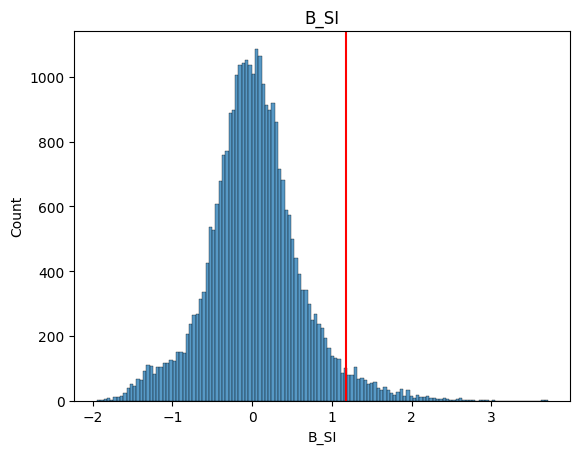

In [50]:
sel = 'B_SI'
fig,ax = plt.subplots(1,1)
sns.histplot(dat[sel])
cutoff = np.sqrt(np.var(dat[sel])) * 2
ax.axvline(x=cutoff, color='red')
ax.set_title(sel)

/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_95931/537867440.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['all', 'p<0.05', 'F_SI', 'F_SI + p', 'B_SI', 'B_SI + p', 'O_SI', 'O_SI + p'])


Text(0.5, 1.0, 'Number of units in dataset')

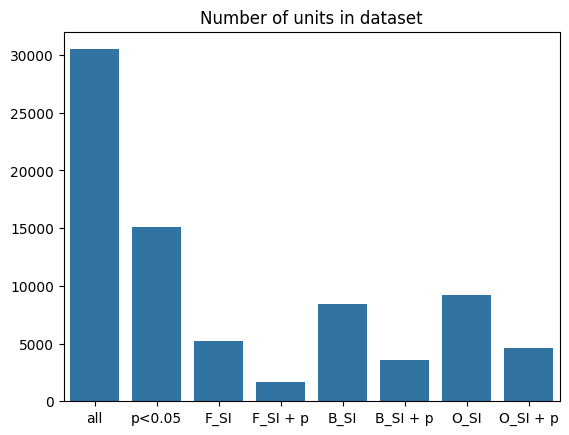

In [72]:
# dat[(dat['p_value']>0.05) & (dat['F_SI']>cutoff)]

fig, ax = plt.subplots(1,1)

sizes = [len(dat)]
inc = np.sum(dat['p_value']>0.05)
sizes.append(inc)
for sel in ['F_SI', 'B_SI', 'O_SI']:
    # cutoff based on n standard deviations
    cutoff = np.sqrt(np.var(dat[sel])) * 0.5
    sizes.append(np.sum(dat[sel]>cutoff))
    sizes.append(np.sum((dat['p_value']>0.05) & (dat[sel]>cutoff)))

sns.barplot(sizes, ax=ax)
ax.set_xticklabels(['all', 'p<0.05', 'F_SI', 'F_SI + p', 'B_SI', 'B_SI + p', 'O_SI', 'O_SI + p'])
ax.set_title('Number of units in dataset')

101it [00:08, 12.45it/s]


<Axes: >

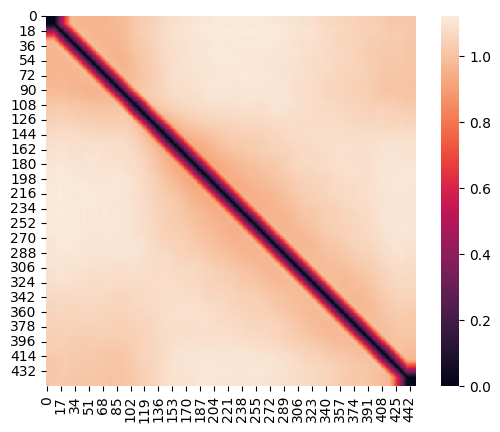

In [8]:
sub_dat = dat[dat['p_value']>0.05]

def unit_rdm(A):
    z = stats.zscore(A, axis=0, nan_policy='omit')  # z-score each image over time
    z = np.nan_to_num(z)
    return squareform(pdist(z, metric='correlation'))  # distance across images

rdms = []
for i, A in tqdm(enumerate(sub_dat['img_psth'])):
    rdm = unit_rdm(A)                 # one RDM per unit
    rdms.append(rdm)

    if i>100:
        break
rdms = np.array(rdms)
mean_rdm = np.nanmean(rdms, axis=0)                     # average across units

sns.heatmap(mean_rdm, square=True)

In [ ]:
np.mean(dat['img_psth'].iloc[0][110:270]) - np.mean(dat['avg_psth'].iloc[0][25:75])

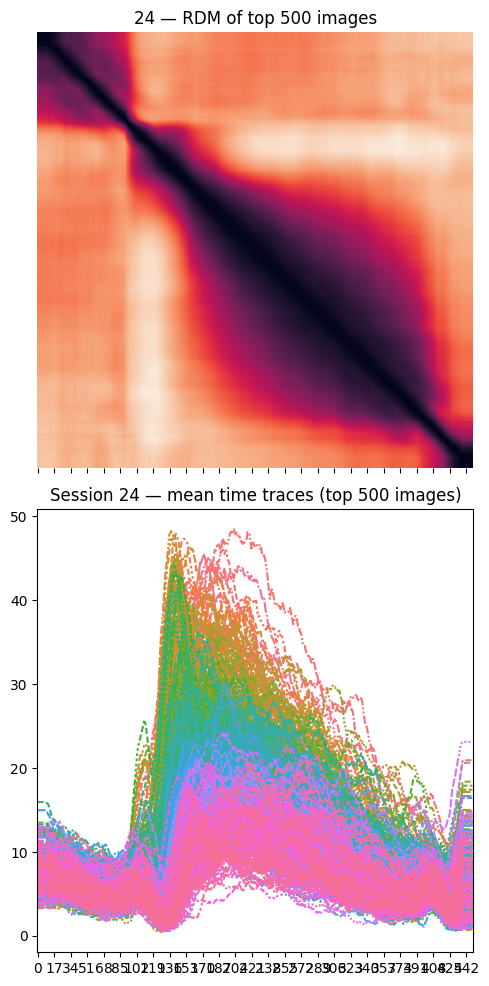

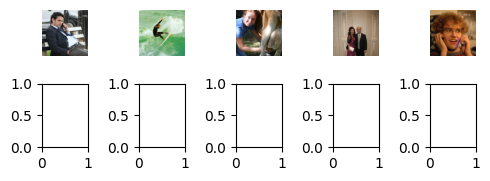

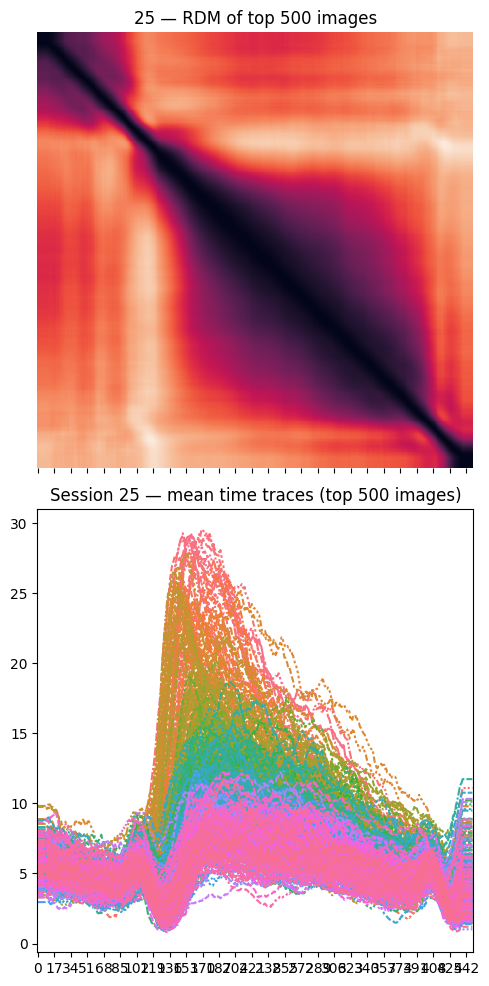

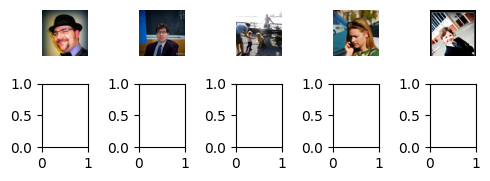

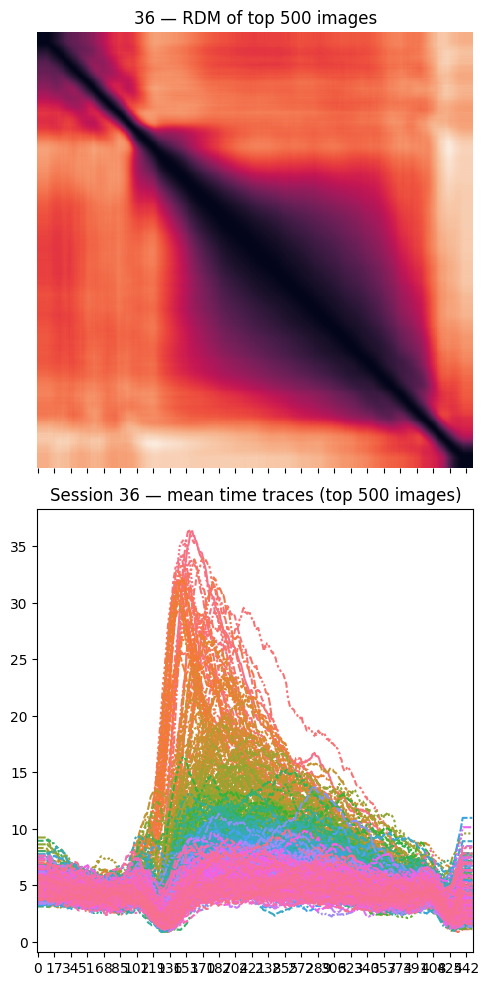

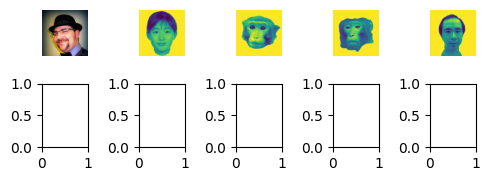

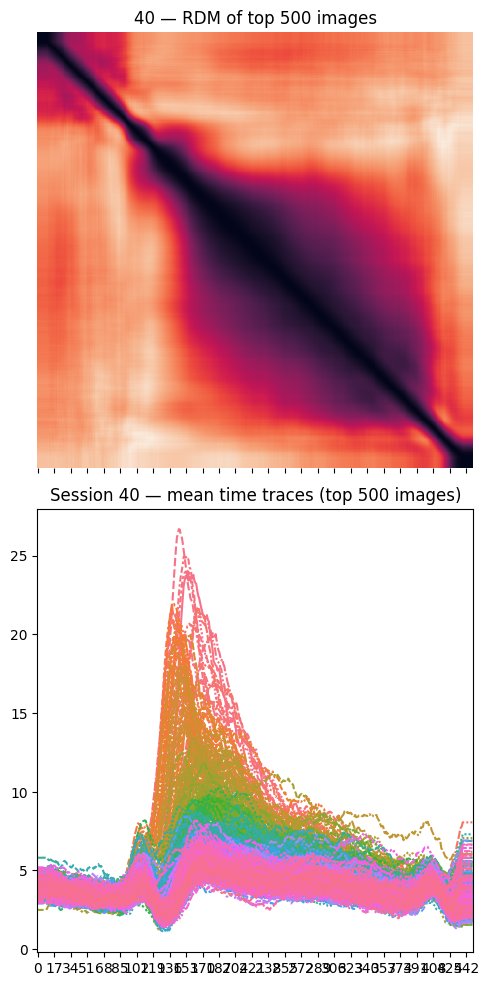

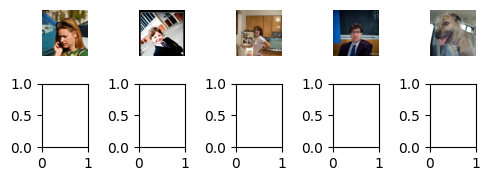

In [57]:
dynamic_face = dat[dat['roi'] == 'MF1_8_F']

ONSET = 50
RESP = slice(ONSET + 50, ONSET + 220)  # 100:270
BASE = slice(ONSET - 50, ONSET + 0)    #   0:50
TOP_N = 500                            # pick top-N images by response-baseline
IMAGE_DIR = "../../datasets/NNN/NSD1000_LOC"
TOP_SHOW = min(TOP_N, 10)

for session in dynamic_face['session'].unique():
    dfdf = dynamic_face[dynamic_face['session'] == session]
    X = np.array([A for A in dfdf['img_psth']])  # (units, time, images)

    # score each image: mean response (50-220) minus baseline (-50–0), averaged across units
    resp = np.nanmean(X[:, RESP, :], axis=(0, 1))
    base = np.nanmean(X[:, BASE, :], axis=(0, 1))
    scores = resp - base

    # top images by score
    top_idx = np.argsort(scores)[-TOP_N:][::-1]

    # average timecourse across units for those images
    Xtop = X[:, :, top_idx]                     # (units, time, top_n)
    Xtop_avg = np.nanmean(Xtop, axis=0)         # (time, top_n)

    # RDM across images (correlation distance on (time) features)
    rdm = squareform(pdist(Xtop_avg, metric='correlation'))
    
    fig, axes = plt.subplots(2,1, figsize=(5, 10), sharex=True)
    # heatmap (images × images)
    sns.heatmap(rdm, square=True, ax=axes[0],
                cbar=False, yticklabels=False)
    axes[0].set_title(f"{session} — RDM of top {TOP_N} images")
    
    # lineplot (time × image)
    sns.lineplot(data=Xtop_avg, legend=False, ax=axes[1])
    axes[1].set_xlim(0, Xtop_avg.shape[0])
    axes[1].set_title(f"Session {session} — mean time traces (top {TOP_N} images)")
    
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(2, 5, figsize=(5, 2))
    axes = axes.ravel()

    top10 = top_idx[:TOP_SHOW]
    for ax, idx in zip(axes, top10):
        if idx < 1000:
            fname = f"{idx+1:04d}.bmp"
        else:
            fname = f"MFOB{idx-999:03d}.bmp"  # 1000→MFOB001, 1071→MFOB072
        fpath = os.path.join(IMAGE_DIR, fname)
        if os.path.exists(fpath):
            img = mpimg.imread(fpath)
            ax.imshow(img)
            ax.set_title('')
            ax.axis("off")
        else:
            ax.text(0.5, 0.5, "missing", ha="center", va="center")
            ax.axis("off")
    
    plt.tight_layout()
    plt.show()
